# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 31, 11:59PM

### Name: SANJEET VINOD JAIN


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned hyper-parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [28]:
#just checking my tensor flow setup with my gpu
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
from tensorflow import keras
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [30]:
import numpy as np
def to_one_hot(y, num_class=10):
   new_y = []
   for values in y :
      encoder = np.zeros(num_class)
      encoder[values] = 1
      new_y.append(encoder)
   return np.asarray(new_y)

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [31]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(x_train,y_train_vec,test_size=0.2,shuffle=True)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [32]:
# Build the model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [33]:
# Define model optimizer and loss function
from keras import optimizers

lr = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = lr), metrics=['acc'])

In [34]:
# Train the model and store model parameters/loss values
history_model_1 = model.fit(x_tr, y_tr, batch_size=40, epochs=100, validation_data=(x_val, y_val))
model.save('model_1.h5')

Epoch 1/100
1000/1000 [==============================] - 6s 5ms/step - loss: 2.7326 - acc: 0.3509 - val_loss: 1.5034 - val_acc: 0.4700
Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: 1.3475 - acc: 0.5285 - val_loss: 1.3015 - val_acc: 0.5470
Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: 1.1283 - acc: 0.6076 - val_loss: 1.2232 - val_acc: 0.5807
Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.9780 - acc: 0.6611 - val_loss: 1.1713 - val_acc: 0.6043
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8541 - acc: 0.7068 - val_loss: 1.1998 - val_acc: 0.6124
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7493 - acc: 0.7420 - val_loss: 1.1342 - val_acc: 0.6347
Epoch 7/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6540 - acc: 0.7766 - val_loss: 1.1531 - val_acc: 0.6308
Epoch 8/100
1000/1000 [==============================] 

## 3. Plot the training and validation loss curve versus epochs. (5 points)

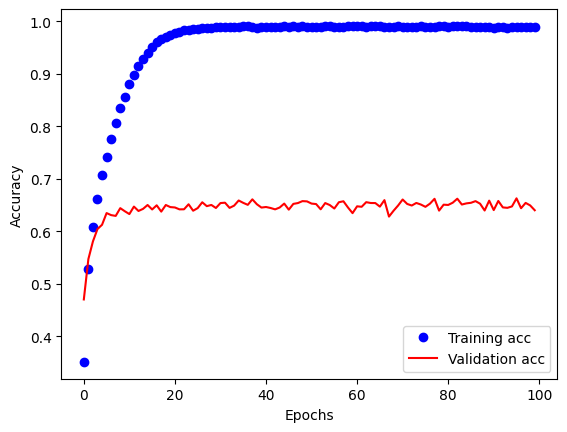

In [35]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

acc = history_model_1.history['acc']
val_acc = history_model_1.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [36]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(32, 32, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation = 'relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0001) , metrics=['acc'])

In [37]:
#<Train your model on the entire training set (50K samples)>

history_model_2 = model.fit(x_train, y_train_vec, batch_size=40, epochs=100)
model.save('model_2.h5')

Epoch 1/100
1250/1250 [==============================] - 6s 5ms/step - loss: 2.6468 - acc: 0.3521
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3796 - acc: 0.5155
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1927 - acc: 0.5857
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0499 - acc: 0.6365
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9441 - acc: 0.6748
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8493 - acc: 0.7096
Epoch 7/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7679 - acc: 0.7387
Epoch 8/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6943 - acc: 0.7650
Epoch 9/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6266 - acc: 0.7887
Epoch 10/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5617 - acc: 0.8104
Epoch 11/100
1250/1

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [38]:
# Evaluate your model performance (testing accuracy) on testing data.
from keras.models import load_model
curr_model = load_model('model_2.h5')
lacc = curr_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(lacc[0]))
print('accuracy = ' + str(lacc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 5.0970 - acc: 0.6392
loss = 5.0970458984375
accuracy = 0.63919997215271


In [39]:
# Evaluate your model performance (testing accuracy) on testing data.

curr_model = load_model('model_1.h5')
lacc = curr_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(lacc[0]))
print('accuracy = ' + str(lacc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 5.9482 - acc: 0.6302
loss = 5.948246002197266
accuracy = 0.6302000284194946


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

In [40]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 64)      

In [41]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator
temp_data = ImageDataGenerator( rotation_range=20, height_shift_range=0.2, width_shift_range=0.2, 
                               zoom_range = 0.2, shear_range = 0.2, horizontal_flip=True)

In [42]:
# Define model optimizer and loss function
lr = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=lr), metrics=['acc'])

In [43]:
# Fits the model on batches with real-time data augmentation

history_model_3 = model.fit(temp_data.flow(x_tr, y_tr, batch_size=40), steps_per_epoch=x_tr.shape[0] // 40, epochs=150, validation_data=(x_val, y_val), validation_batch_size=x_val.shape[0] // 40)
model.save('model_3.h5')

Epoch 1/150
1000/1000 [==============================] - 16s 15ms/step - loss: 1.6966 - acc: 0.3906 - val_loss: 1.4487 - val_acc: 0.4799
Epoch 2/150
1000/1000 [==============================] - 14s 14ms/step - loss: 1.4731 - acc: 0.4708 - val_loss: 1.3137 - val_acc: 0.5318
Epoch 3/150
1000/1000 [==============================] - 14s 14ms/step - loss: 1.3766 - acc: 0.5098 - val_loss: 1.2442 - val_acc: 0.5650
Epoch 4/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.3219 - acc: 0.5313 - val_loss: 1.2809 - val_acc: 0.5531
Epoch 5/150
1000/1000 [==============================] - 14s 14ms/step - loss: 1.2678 - acc: 0.5492 - val_loss: 1.2237 - val_acc: 0.5786
Epoch 6/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.2440 - acc: 0.5563 - val_loss: 1.1327 - val_acc: 0.6032
Epoch 7/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.2040 - acc: 0.5690 - val_loss: 1.0012 - val_acc: 0.6441
Epoch 8/150
1000/1000 [==================

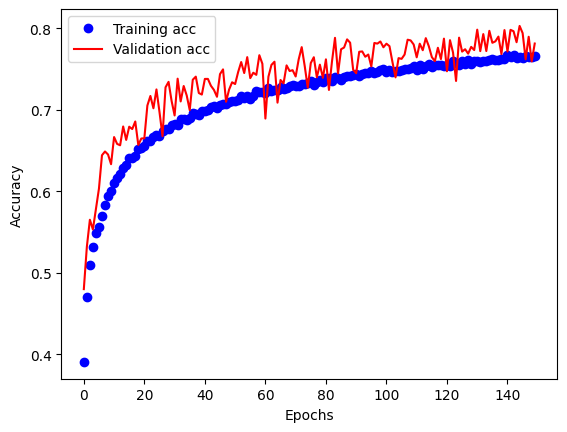

In [44]:
# Plot the loss curve

import matplotlib.pyplot as plt
%matplotlib inline

acc = history_model_3.history['acc']
val_acc = history_model_3.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.legend()
plt.show()

# Train (again) and evaluate the model
To this end, you have found the "best" hyper-parameters.
Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
Evaluate your model on the test set.

# Train the model on the entire training set
Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [45]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = lr) , metrics=['acc'])

# Data augmentation

temp_data = ImageDataGenerator( rotation_range=20, height_shift_range=0.2, width_shift_range=0.2, 
                               zoom_range = 0.2, shear_range = 0.2, horizontal_flip=True)

In [46]:
# Train the model and store model parameters/loss values

history_model_4 = model.fit(temp_data.flow(x_train, y_train_vec, batch_size=40), steps_per_epoch=x_tr.shape[0] // 32, epochs=150)
model.save('model_4.h5')

Epoch 1/150
1250/1250 [==============================] - 18s 13ms/step - loss: 1.6739 - acc: 0.4005
Epoch 2/150
1250/1250 [==============================] - 16s 13ms/step - loss: 1.4322 - acc: 0.4883
Epoch 3/150
1250/1250 [==============================] - 17s 13ms/step - loss: 1.3354 - acc: 0.5220
Epoch 4/150
1250/1250 [==============================] - 17s 13ms/step - loss: 1.2737 - acc: 0.5492
Epoch 5/150
1250/1250 [==============================] - 16s 13ms/step - loss: 1.2268 - acc: 0.5642
Epoch 6/150
1250/1250 [==============================] - 16s 13ms/step - loss: 1.1927 - acc: 0.5767
Epoch 7/150
1250/1250 [==============================] - 17s 13ms/step - loss: 1.1588 - acc: 0.5890
Epoch 8/150
1250/1250 [==============================] - 16s 13ms/step - loss: 1.1307 - acc: 0.6025
Epoch 9/150
1250/1250 [==============================] - 16s 13ms/step - loss: 1.1073 - acc: 0.6101
Epoch 10/150
1250/1250 [==============================] - 16s 13ms/step - loss: 1.0878 - acc: 0.6177

# Evaluate the model on the test set
Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [47]:
# Evaluate your model performance (testing accuracy) on testing data.

curr_model = load_model('model_3.h5')
lacc = curr_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(lacc[0]))
print('accuracy = ' + str(lacc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.6738 - acc: 0.7767
loss = 0.6738083958625793
accuracy = 0.7767000198364258


In [48]:
# Evaluate your model performance (testing accuracy) on testing data.

curr_model = load_model('model_4.h5')
lacc = curr_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(lacc[0]))
print('accuracy = ' + str(lacc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.6640 - acc: 0.7904
loss = 0.6639710664749146
accuracy = 0.7904000282287598


# Second Model using Batch Normalization and Dropout

In [49]:
# Build the model


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_7 (Batc  (None, 12, 12, 64)      

In [50]:
# Define model optimizer and loss function

lr = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=lr), metrics=['acc'])

In [51]:
# Train the model and store model parameters/loss values

history_model_5 = model.fit(x_tr, y_tr, batch_size=40, epochs=100, validation_data=(x_val, y_val))
model.save('model_5.h5')

Epoch 1/100
1000/1000 [==============================] - 8s 7ms/step - loss: 1.6626 - acc: 0.4042 - val_loss: 1.2909 - val_acc: 0.5464
Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: 1.3339 - acc: 0.5246 - val_loss: 1.1450 - val_acc: 0.6008
Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: 1.2164 - acc: 0.5698 - val_loss: 1.0627 - val_acc: 0.6249
Epoch 4/100
1000/1000 [==============================] - 8s 8ms/step - loss: 1.1331 - acc: 0.6003 - val_loss: 1.0147 - val_acc: 0.6442
Epoch 5/100
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0691 - acc: 0.6248 - val_loss: 0.9486 - val_acc: 0.6667
Epoch 6/100
1000/1000 [==============================] - 9s 9ms/step - loss: 1.0272 - acc: 0.6398 - val_loss: 0.9513 - val_acc: 0.6667
Epoch 7/100
1000/1000 [==============================] - 8s 8ms/step - loss: 0.9915 - acc: 0.6500 - val_loss: 0.9319 - val_acc: 0.6728
Epoch 8/100
1000/1000 [==============================] 

# Plot the training and validation loss curve versus epochs.

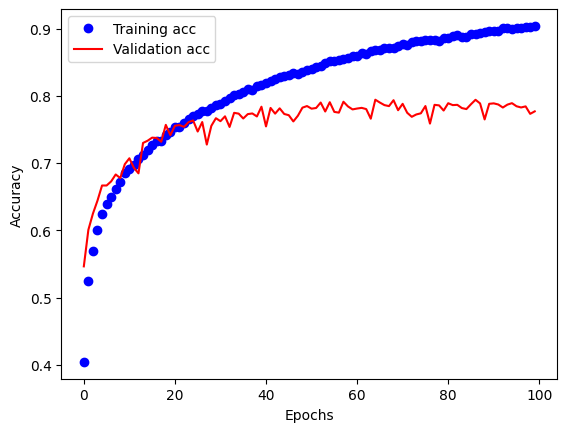

In [52]:
# Plot the loss curve

import matplotlib.pyplot as plt
%matplotlib inline

acc = history_model_5.history['acc']
val_acc = history_model_5.history['val_acc']

epochs = range(len(acc))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.legend()
plt.show()

# Train (again) and evaluate the model
To this end, you have found the "best" hyper-parameters.
Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
Evaluate your model on the test set.

# Train the model on the entire training set
Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [53]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=lr), metrics=['acc'])

In [54]:
# Train the model and store model parameters/loss values

history_model_6 = model.fit(x_train, y_train_vec, batch_size=40, epochs=100)
model.save('model_6.h5')

Epoch 1/100
1250/1250 [==============================] - 10s 7ms/step - loss: 1.6347 - acc: 0.4141
Epoch 2/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3078 - acc: 0.5313
Epoch 3/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.1872 - acc: 0.5811
Epoch 4/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.1049 - acc: 0.6104
Epoch 5/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0417 - acc: 0.6333
Epoch 6/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0046 - acc: 0.6475
Epoch 7/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9650 - acc: 0.6603
Epoch 8/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9331 - acc: 0.6717
Epoch 9/100
1250/1250 [==============================] - 9s 8ms/step - loss: 0.9060 - acc: 0.6836
Epoch 10/100
1250/1250 [==============================] - 9s 8ms/step - loss: 0.8777 - acc: 0.6942
Epoch 11/100
1250/

# Evaluate the model on the test set
Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [55]:
# Evaluate your model performance (testing accuracy) on testing data.

curr_model = load_model('model_5.h5')
lacc = curr_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(lacc[0]))
print('accuracy = ' + str(lacc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.7733 - acc: 0.7735
loss = 0.7732677459716797
accuracy = 0.7735000252723694


In [56]:
# Evaluate your model performance (testing accuracy) on testing data.

curr_model = load_model('model_6.h5')
lacc = curr_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(lacc[0]))
print('accuracy = ' + str(lacc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.7335 - acc: 0.7812
loss = 0.7335073351860046
accuracy = 0.7811999917030334


# Comparision and Analysis:
*Normal CNN model:* is not that efficient and has an accuracy of 69 % and after using full training dataset it achieves accuracy of 70 %. *My first model* which uses data augmentation and batch normalization has a accuracy of 66 % and after using full training dataset it achieves has accuracy of ~78 %. *My second and final model* which uses batch normaliztion and dropout has an accuracy of 78 % and after using full training dataset it achieves an accuracy of ~80 %.

*Hence, I think model 2 is the best model, I could make considering the time and the limited availability of Google Colab's GPU feature.*